In [11]:
# Install required packages
!pip install pandas scikit-learn matplotlib seaborn transformers datasets accelerate --quiet

### Install GPU-enabled PyTorch and xformers

The following cell installs the version of PyTorch that can use your NVIDIA GPU. It specifically targets CUDA 11.8, which has wide compatibility. After running this cell, you **must restart the kernel** for the changes to take effect.

**Action Required**:
1. Run the cell below.
2. From the menu above, select **Kernel > Restart Kernel**.
3. Run all the cells again from the beginning.

In [12]:
import sys
import subprocess

def run_pip(args):
    try:
        subprocess.run([sys.executable, "-m", "pip"] + args, check=True, capture_output=True, text=True)
        print(f"Successfully ran pip {' '.join(args)}")
    except subprocess.CalledProcessError as e:
        print(f"Error running pip {' '.join(args)}:")
        print(e.stdout)
        print(e.stderr)

print("--- Uninstalling existing packages ---")
run_pip(["uninstall", "torch", "torchvision", "torchaudio", "xformers", "-y"])

print("\n--- Installing CUDA-enabled PyTorch ---")
run_pip(["install", "torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cu118"])

print("\n--- Installing xformers ---")
run_pip(["install", "xformers"])

print("\n✅ Installation complete! Please restart the kernel now.")

--- Uninstalling existing packages ---
Successfully ran pip uninstall torch torchvision torchaudio xformers -y

--- Installing CUDA-enabled PyTorch ---
Successfully ran pip uninstall torch torchvision torchaudio xformers -y

--- Installing CUDA-enabled PyTorch ---
Successfully ran pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

--- Installing xformers ---
Successfully ran pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

--- Installing xformers ---
Successfully ran pip install xformers

✅ Installation complete! Please restart the kernel now.
Successfully ran pip install xformers

✅ Installation complete! Please restart the kernel now.


### Verify GPU and Import Libraries

This cell imports all necessary libraries and, most importantly, verifies that PyTorch can detect and use your GPU. If CUDA is not available after restarting the kernel, please check your NVIDIA driver and CUDA Toolkit installation.

In [13]:
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 2. Data Loading and Preparation {#data}

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset

import matplotlib.pyplot as plt
import torch.nn as nn

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

# Check for GPU availability and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU detected: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("⚠️ No GPU detected, using CPU. This will be significantly slower.")

# Set a consistent style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Using device: {device}")

✅ GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU
Using device: cuda


In [15]:
# --- Data Loading ---
print("\n📂 Loading cleaned dataset...")
try:
    df = pd.read_csv('dataset/cleaned_dataset.csv')
    print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    print("❌ cleaned_dataset.csv not found! Please ensure it is in the 'dataset' folder.")

# --- Data Splitting ---
print("\n🔨 Splitting data...")
df_clean = df[['text', 'label']].copy()
df_clean.columns = ['text', 'label']
df_clean = df_clean.dropna()

train_data, temp_data = train_test_split(df_clean, test_size=0.3, random_state=42, stratify=df_clean['label'])
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42, stratify=temp_data['label'])

print(f"📈 Data splits:")
print(f"   Training:   {len(train_data)} samples")
print(f"   Validation: {len(val_data)} samples")
print(f"   Test:       {len(test_data)} samples")


📂 Loading cleaned dataset...
✅ Dataset loaded successfully! Shape: (40432, 4)

🔨 Splitting data...
📈 Data splits:
   Training:   28302 samples
   Validation: 8086 samples
   Test:       4044 samples


# 3. Method 1: Stella Embeddings + ML Classifiers {#method1}

In [17]:
print("🚀 Loading Stella model for feature extraction...")
stella_model_name = "NovaSearch/stella_en_400M_v5"

# Load config and disable features causing errors
config = AutoConfig.from_pretrained(stella_model_name, trust_remote_code=True)
config.use_memory_efficient_attention = False
config.unpad_inputs = False

tokenizer = AutoTokenizer.from_pretrained(stella_model_name)

🚀 Loading Stella model for feature extraction...


In [ ]:

# Load the model with the modified configuration
model = AutoModel.from_pretrained(stella_model_name, config=config, trust_remote_code=True, torch_dtype="auto")
model.to(device)
model.eval()

def get_stella_embeddings(texts, batch_size=16):
    print(f"Generating embeddings for {len(texts)} texts...")
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
            outputs = model(**inputs)
            # Average pooling
            embeddings = outputs.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

# Generate embeddings for all data splits
X_train_ml = get_stella_embeddings(train_data['text'].tolist())
X_val_ml = get_stella_embeddings(val_data['text'].tolist())
X_test_ml = get_stella_embeddings(test_data['text'].tolist())

y_train = train_data['label'].values
y_val = val_data['label'].values
y_test = test_data['label'].values

print(f"\n✅ Embeddings generated!")
print(f"   Train embeddings shape: {X_train_ml.shape}")

In [11]:
import numpy as np
import os

# --- Save Embeddings and Labels ---
print("Saving embeddings and labels to disk...")

# Create a directory to store embeddings
output_dir = "stella_embeddings"
os.makedirs(output_dir, exist_ok=True)

# Save each array to a compressed .npz file
np.savez_compressed(
    os.path.join(output_dir, "stella_embeddings.npz"),
    X_train=X_train_ml,
    X_val=X_val_ml,
    X_test=X_test_ml,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test
)

print(f"✅ Embeddings and labels saved to '{output_dir}/stella_embeddings.npz'")

Saving embeddings and labels to disk...
✅ Embeddings and labels saved to 'stella_embeddings/stella_embeddings.npz'
✅ Embeddings and labels saved to 'stella_embeddings/stella_embeddings.npz'


In [12]:
print("🎯 Training ML classifiers on Stella embeddings...")

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True)
}

ml_results = {}
for name, clf in classifiers.items():
    print(f"\n--- Training {name} ---")
    clf.fit(X_train_ml, y_train)
    y_pred = clf.predict(X_test_ml)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    ml_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'report': classification_report(y_test, y_pred),
        'cm': cm
    }

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

🎯 Training ML classifiers on Stella embeddings...

--- Training Logistic Regression ---
Accuracy: 0.9149
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2022
           1       0.92      0.91      0.91      2022

    accuracy                           0.91      4044
   macro avg       0.92      0.91      0.91      4044
weighted avg       0.92      0.91      0.91      4044


--- Training SVM ---
Accuracy: 0.9149
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2022
           1       0.92      0.91      0.91      2022

    accuracy                           0.91      4044
   macro avg       0.92      0.91      0.91      4044
weighted avg       0.92      0.91      0.91      4044


--- Training SVM ---
Accuracy: 0.9127
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      

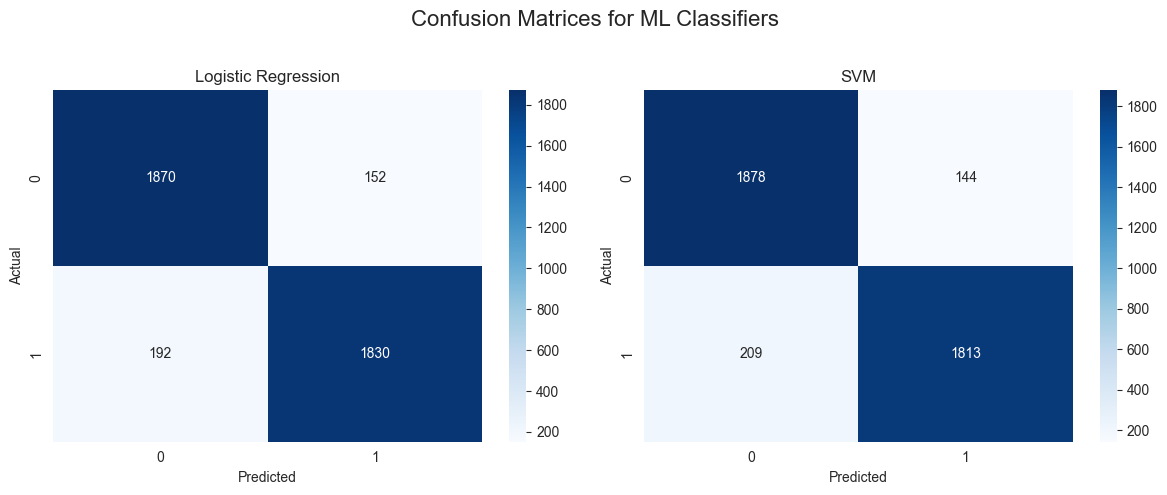

In [13]:
fig, axes = plt.subplots(1, len(classifiers), figsize=(12, 5))
fig.suptitle('Confusion Matrices for ML Classifiers', fontsize=16)

for i, (name, result) in enumerate(ml_results.items()):
    ax = axes[i]
    sns.heatmap(result['cm'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4. Method 2: Stella Embeddings + DL Classifier {#method2}

In [18]:
print("🧠 Defining a more complex DL classifier...")

class ComplexClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.5):
        super(ComplexClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# Use embeddings from Method 1
X_train_dl = torch.tensor(X_train_ml, dtype=torch.float32)
y_train_dl = torch.tensor(y_train, dtype=torch.long)
X_val_dl = torch.tensor(X_val_ml, dtype=torch.float32)
y_val_dl = torch.tensor(y_val, dtype=torch.long)
X_test_dl = torch.tensor(X_test_ml, dtype=torch.float32)
y_test_dl = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset_dl = TensorDataset(X_train_dl, y_train_dl)
train_loader_dl = DataLoader(train_dataset_dl, batch_size=32, shuffle=True)
val_dataset_dl = TensorDataset(X_val_dl, y_val_dl)
val_loader_dl = DataLoader(val_dataset_dl, batch_size=32, shuffle=False)


# Model, Loss, Optimizer
input_dim = X_train_dl.shape[1]
dl_classifier = ComplexClassifier(
    input_dim=input_dim,
    hidden_dim1=256,
    hidden_dim2=128,
    output_dim=2,
    dropout_rate=0.5
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dl_classifier.parameters(), lr=0.001)

print("✅ Complex DL Classifier setup complete.")

🧠 Defining a more complex DL classifier...
✅ Complex DL Classifier setup complete.


🎯 Training the Complex DL classifier with Early Stopping...
Epoch [1/20], Train Loss: 0.3604, Val Loss: 0.2628
   -> Validation loss improved. Saving model.
Epoch [1/20], Train Loss: 0.3604, Val Loss: 0.2628
   -> Validation loss improved. Saving model.
Epoch [2/20], Train Loss: 0.2773, Val Loss: 0.2431
   -> Validation loss improved. Saving model.
Epoch [2/20], Train Loss: 0.2773, Val Loss: 0.2431
   -> Validation loss improved. Saving model.
Epoch [3/20], Train Loss: 0.2551, Val Loss: 0.2247
   -> Validation loss improved. Saving model.
Epoch [3/20], Train Loss: 0.2551, Val Loss: 0.2247
   -> Validation loss improved. Saving model.
Epoch [4/20], Train Loss: 0.2387, Val Loss: 0.2115
   -> Validation loss improved. Saving model.
Epoch [4/20], Train Loss: 0.2387, Val Loss: 0.2115
   -> Validation loss improved. Saving model.
Epoch [5/20], Train Loss: 0.2246, Val Loss: 0.2143
   -> Validation loss did not improve. Patience: 1/3
Epoch [5/20], Train Loss: 0.2246, Val Loss: 0.2143
   -> Val

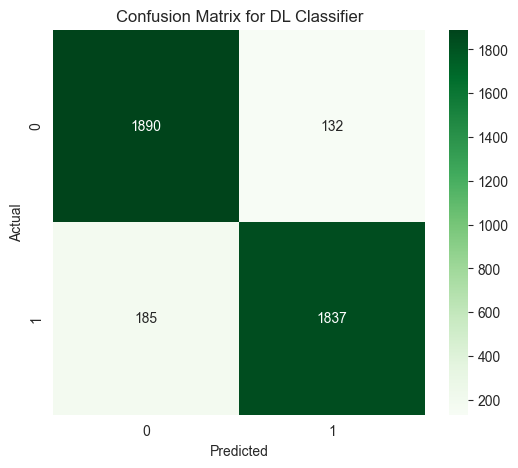

In [19]:
print("🎯 Training the Complex DL classifier with Early Stopping...")

# Early Stopping parameters
patience = 3
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 20 # Increased number of epochs

for epoch in range(num_epochs):
    # --- Training Phase ---
    dl_classifier.train()
    total_train_loss = 0
    for embeddings, labels in train_loader_dl:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = dl_classifier(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader_dl)

    # --- Validation Phase ---
    dl_classifier.eval()
    total_val_loss = 0
    with torch.no_grad():
        for embeddings, labels in val_loader_dl:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            outputs = dl_classifier(embeddings)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader_dl)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model state
        torch.save(dl_classifier.state_dict(), 'best_complex_classifier.pth')
        print(f'   -> Validation loss improved. Saving model.')
    else:
        patience_counter += 1
        print(f'   -> Validation loss did not improve. Patience: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("   -> Early stopping triggered.")
            break

# Load the best model for evaluation
print("\n🔄 Loading best model for final evaluation...")
dl_classifier.load_state_dict(torch.load('best_complex_classifier.pth'))

print("\n🧪 Evaluating the DL classifier...")
dl_classifier.eval()
with torch.no_grad():
    outputs = dl_classifier(X_test_dl.to(device))
    _, predicted = torch.max(outputs.data, 1)
    y_pred_dl = predicted.cpu().numpy()

accuracy_dl = accuracy_score(y_test_dl.numpy(), y_pred_dl)
precision_dl, recall_dl, f1_dl, _ = precision_recall_fscore_support(y_test_dl.numpy(), y_pred_dl, average='weighted')
cm_dl = confusion_matrix(y_test_dl.numpy(), y_pred_dl)

dl_results = {
    'accuracy': accuracy_dl,
    'precision': precision_dl,
    'recall': recall_dl,
    'f1': f1_dl,
    'report': classification_report(y_test_dl.numpy(), y_pred_dl),
    'cm': cm_dl
}

print(f"Accuracy: {accuracy_dl:.4f}")
print("Classification Report:")
print(dl_results['report'])

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for DL Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 5. Method 3: End-to-End Stella Fine-tuning {#method3}

In [9]:
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput

# The AutoModelForSequenceClassification class doesn't know the Stella architecture.
# We create a custom class to wrap the base Stella model with a classification head.
class StellaForSequenceClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(StellaForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        
        # Load config and disable features causing errors
        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        config.use_memory_efficient_attention = False
        config.unpad_inputs = False
        
        # Load the base Stella model with the modified config
        self.stella = AutoModel.from_pretrained(model_name, config=config, trust_remote_code=True)
        self.config = self.stella.config
        
        # Add a classification head
        self.dropout = torch.nn.Dropout(0.1)  # Use a fixed dropout rate
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Filter out unexpected kwargs that the base model doesn't understand
        model_kwargs = {}
        if input_ids is not None:
            model_kwargs['input_ids'] = input_ids
        if attention_mask is not None:
            model_kwargs['attention_mask'] = attention_mask
        
        # Get the output from the base model
        outputs = self.stella(**model_kwargs)
        
        # Use mean pooling of the last hidden state instead of pooler_output
        last_hidden_state = outputs.last_hidden_state
        if attention_mask is not None:
            # Apply attention mask and compute mean
            masked_hidden_state = last_hidden_state * attention_mask.unsqueeze(-1)
            pooled_output = masked_hidden_state.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)
        else:
            # Simple mean pooling
            pooled_output = last_hidden_state.mean(dim=1)
            
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # Return an object compatible with the Hugging Face Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    
    # Required for Hugging Face Trainer compatibility
    def to(self, device):
        self.stella.to(device)
        self.classifier.to(device)
        return self
        
    @property
    def device(self):
        return self.stella.device
    
    # Add gradient checkpointing support
    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        """Enable gradient checkpointing for the underlying Stella model."""
        if hasattr(self.stella, 'gradient_checkpointing_enable'):
            self.stella.gradient_checkpointing_enable(gradient_checkpointing_kwargs)
        else:
            # Fallback: set gradient_checkpointing on the model directly
            self.stella.gradient_checkpointing = True
    
    def gradient_checkpointing_disable(self):
        """Disable gradient checkpointing for the underlying Stella model."""
        if hasattr(self.stella, 'gradient_checkpointing_disable'):
            self.stella.gradient_checkpointing_disable()
        else:
            # Fallback: set gradient_checkpointing on the model directly
            self.stella.gradient_checkpointing = False

In [18]:
print("🚀 Loading Stella model for Sequence Classification...")

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Load our custom model with a classification head
model_ft = StellaForSequenceClassification(
    model_name=stella_model_name,
    num_labels=2
).to(device)

print("✅ Model and data prepared for fine-tuning.")

🚀 Loading Stella model for Sequence Classification...


Map: 100%|██████████| 4044/4044 [00:00<00:00, 10539.98 examples/s]

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.7.1+cu126 with CUDA 1208 (you have 2.7.1+cu118)
    Python  3.9.13 (you have 3.13.3)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.7.1+cu126 with CUDA 1208 (you have 2.7.1+cu118)
    Python  3.9.13 (you have 3.13.3)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.

✅ Model and data prepared for fine-tuning.


In [19]:
import torch
torch.cuda.empty_cache()

In [21]:
print("🎯 Setting up Trainer API...")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Memory-optimized training arguments
training_args = TrainingArguments(
    output_dir="./stella-fine-tuned",
    num_train_epochs=3,  # Reduced epochs
    per_device_train_batch_size=8,  # Very small batch size
    per_device_eval_batch_size=8,   # Small eval batch size
    gradient_accumulation_steps=4,  # Simulate larger batch size
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),  # Enable mixed-precision training
    dataloader_pin_memory=False,     # Reduce memory usage
    remove_unused_columns=True,      # Remove unused columns to save memory
    gradient_checkpointing=True,     # Enable gradient checkpointing
    max_grad_norm=1.0,              # Gradient clipping for stability
)

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

print("🚀 Starting fine-tuning with optimized memory settings...")
try:
    trainer.train()
    print("✅ Training completed successfully!")
except Exception as e:
    print(f"❌ Training failed with error: {e}")
    print("Trying with gradient checkpointing disabled...")
    
    # Fallback: disable gradient checkpointing
    training_args.gradient_checkpointing = False
    trainer = Trainer(
        model=model_ft,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )
    trainer.train()

print("\n🧪 Evaluating the fine-tuned model...")
eval_results = trainer.evaluate(eval_dataset=tokenized_test)
predictions = trainer.predict(tokenized_test)
y_pred_ft = predictions.predictions.argmax(axis=1)
y_true_ft = tokenized_test['label']

cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

ft_results = {
    'accuracy': eval_results['eval_accuracy'],
    'precision': eval_results['eval_precision'],
    'recall': eval_results['eval_recall'],
    'f1': eval_results['eval_f1'],
    'report': classification_report(y_true_ft, y_pred_ft),
    'cm': cm_ft
}

print("\n📊 Test Set Evaluation Results:")
for key, value in eval_results.items():
    print(f"   {key}: {value:.4f}")

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix for Fine-Tuned Stella')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

🎯 Setting up Trainer API...
🚀 Starting fine-tuning with optimized memory settings...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# 6. Model Comparison and Conclusion {#conclusion}

In [ ]:
print("📊 Final Comparison of All Methods")
print("="*50)

# Consolidate results into a DataFrame for easy comparison
comparison_data = []
for name, result in ml_results.items():
    comparison_data.append(['Method 1: ML', name, result['accuracy'], result['precision'], result['recall'], result['f1']])

comparison_data.append(['Method 2: DL', 'Simple NN', dl_results['accuracy'], dl_results['precision'], dl_results['recall'], dl_results['f1']])
comparison_data.append(['Method 3: Fine-tune', 'Fine-tuned Stella', ft_results['accuracy'], ft_results['precision'], ft_results['recall'], ft_results['f1']])

results_df = pd.DataFrame(comparison_data, columns=['Method', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
results_df_sorted = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\n📈 Performance Metrics Comparison:")
print(results_df_sorted.to_string())

# --- Visualization of Results ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=20)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    sns.barplot(data=results_df_sorted, x=metric, y='Model', ax=ax, palette='viridis', orient='h')
    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_xlabel('Score')
    ax.set_ylabel('')
    ax.set_xlim(0.8, 1.0)
    # Add value labels
    for index, value in enumerate(results_df_sorted[metric]):
        ax.text(value + 0.005, index, f'{value:.3f}', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Best Model Report ---
best_model_name = results_df_sorted.iloc[0]['Model']
best_method = results_df_sorted.iloc[0]['Method']
print(f"\n🏆 Best Performing Model: {best_model_name} ({best_method}) 🏆")

if 'Fine-tune' in best_method:
    print(ft_results['report'])
elif 'DL' in best_method:
    print(dl_results['report'])
else:
    print(ml_results[best_model_name]['report'])

In [ ]:
# 5. Method 3: End-to-End Stella Fine-tuning with QLoRA

In [1]:
# ==============================================================================
# Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset

from transformers import (
    AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, BitsAndBytesConfig
)
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'peft'